In [1]:
from scripts import mapcalc_kde
import pandas as pd
import numpy as np
import dill

In [3]:
# read in geocoded datasets as Pandas dataframes
arrests = pd.read_csv('Django_old/clean_data/arrests_GIS.csv')
schools = pd.read_csv('Django_old/clean_data/school_list_GIS.csv')
restaurants = pd.read_csv('Django_old/clean_data/restaurant_list_GIS.csv')
restaurants = restaurants[restaurants['Longitude'] < 0] # filter out bad values
groceries = pd.read_csv('Django_old/clean_data/grocerystore_list_GIS.csv')
vacancies = pd.read_csv('Django_old/clean_data/vacancies_GIS.csv')
museums = pd.read_csv('Django_old/clean_data/museums_GIS.csv')
parks = pd.read_csv('Django_old/clean_data/parks_GIS.csv')
liquor = pd.read_csv('Django_old/clean_data/Liquor_GIS.csv')
libraries = pd.read_csv('Django_old/clean_data/Libraries_GIS.csv')

In [ ]:
"""
Compute and dump kernels as dill files.
"""

bandwidth = None # Choose 'None' for Scott-type bandwidth determination

# names of datasets, in order
datas = [arrests, vacancies, groceries, restaurants, schools, museums, parks, liquor, libraries]
names = ['crime', 'vacancy', 'grocery', 'restaurant', 'schools', 'museums', 'parks', 'liquor', 'libraries']

# loop through and dump kernels into dills/
for i in range(len(names)):
    kernel = mapcalc_kde.compute_kde(datas[i]['Longitude'], datas[i]['Latitude'], 0.15)
    dill.dump(kernel, open('dills/'+names[i]+'_dynamicBW.dill', 'w'))

In [4]:
# load the kernels
crime = dill.load(open('dills/crime_dynamicBW.dill', 'r'))
vacancy = dill.load(open('dills/vacancy_dynamicBW.dill', 'r'))
grocery = dill.load(open('dills/grocery_dynamicBW.dill', 'r'))
restaurant = dill.load(open('dills/restaurant_dynamicBW.dill', 'r'))
schools = dill.load(open('dills/schools_dynamicBW.dill', 'r'))
museums = dill.load(open('dills/museums_dynamicBW.dill', 'r'))
parks = dill.load(open('dills/parks_dynamicBW.dill', 'r'))
liquor = dill.load(open('dills/liquor_dynamicBW.dill', 'r'))
libraries = dill.load(open('dills/libraries_dynamicBW.dill', 'r'))

In [6]:
"""Define map and grid of points at which to compute kernel densities"""

# Boundary conditions for all maps (longitudes as x vals, latitudes as y vals)
lonmin = -76.72
lonmax = -76.52
latmin = 39.19
latmax = 39.38

# number of points along each map edge
# (total number of points is npts**2)
npts = 200

#generate appropriate lon/lat grid
x = np.linspace(lonmin, lonmax, npts)
y = np.linspace(latmin, latmax, npts)
X, Y = np.meshgrid(x, y, indexing='ij')

# array of (lon/lat) pairs
positions = np.vstack([X.ravel(), Y.ravel()])

# compute individual maps
crime_map = mapcalc_kde.kde_map(x, y, crime)
vacancy_map = mapcalc_kde.kde_map(x, y, vacancy)
grocery_map = mapcalc_kde.kde_map(x, y, grocery)
restaurant_map = mapcalc_kde.kde_map(x, y, restaurant)
schools_map = mapcalc_kde.kde_map(x, y, schools)
museums_map = mapcalc_kde.kde_map(x, y, museums)
parks_map = mapcalc_kde.kde_map(x, y, parks)
liquor_map = mapcalc_kde.kde_map(x, y, liquor)
libraries_map = mapcalc_kde.kde_map(x, y, libraries)

# build a dataframe of all maps (as flattened arrays of length npts**2)
map_df = pd.DataFrame({
        'crime':crime_map, 
        'vacancy':vacancy_map, 
        'grocery':grocery_map, 
        'restaurant':restaurant_map, 
        'schools':schools_map,
        'museums':museums_map,
        'parks':parks_map,
        'liquor':liquor_map,
        'libraries':libraries_map
    })

# dump the whole dataframe
dill.dump(map_df, open('dills/map_df_dynamicBW.dill', 'w'))

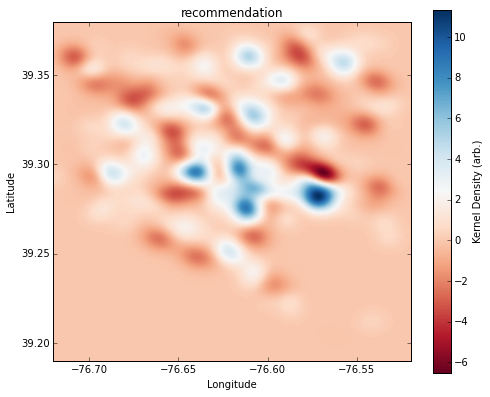

In [25]:
crime_mult      = -1
vacancy_mult    = -1
grocery_mult    = 1
restaurant_mult = 1
schools_mult    = 0
museums_mult    = 1
parks_mult      = 0
liquor_mult     = 0
libraries_mult  = 0

mults = np.array([
        crime_mult, 
        vacancy_mult, 
        grocery_mult, 
        restaurant_mult, 
        schools_mult, 
        museums_mult,
        parks_mult,
        liquor_mult,
        libraries_mult
    ])
#map_df = dill.load(open('dills/map_df_dynamicBW.dill'))
mult_map_df = map_df*mults
rec_map = mult_map_df.sum(axis=1).values
#to_gmap = mapcalc_kde.produce_google_heatmap_points(rec_map, npts, positions, 0.9)
plot_KDE(x, y, rec_map, 'recommendation')

In [7]:
map_df.head()

,crime,grocery,libraries,liquor,museums,parks,restaurant,schools,vacancy
0,5.088847e-87,2.618883e-70,6.979711e-101,1.095003e-102,0,5.690792e-61,3.182468e-111,3.119554e-66,1.397577e-134
1,3.563095e-86,1.538481e-69,1.390680e-99,1.713214e-101,0,2.673168e-61,6.786135e-110,1.465327e-65,2.317007e-133
2,2.442262e-85,8.821201e-69,2.695054e-98,2.574093e-100,0,1.216941e-61,1.398845e-108,6.724521e-65,3.697070e-132
3,1.640220e-84,4.936547e-68,5.078877e-97,3.714098e-99,0,5.369110e-62,2.783692e-107,3.014882e-64,5.677247e-131
4,1.080451e-83,2.696370e-67,9.307029e-96,5.146343e-98,0,2.295752e-62,5.341087e-106,1.320566e-63,8.389611e-130


In [24]:
from sklearn.cluster import KMeans
def plot_KDE(lons, lats, kernel_density, mapname):
    plt.figure(figsize=(8, 6.5))
    plt.imshow(
        np.rot90(np.reshape(kernel_density, (len(lons), len(lats))).T),
        cmap=plt.cm.RdBu,
        extent=[min(lons), max(lons), min(lats), max(lats)]
    )
    plt.axis([min(lons), max(lons), min(lats), max(lats)])
    plt.title(mapname)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Kernel Density (arb.)')

In [40]:
%matplotlib

Using matplotlib backend: MacOSX


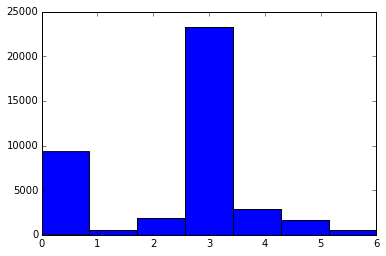

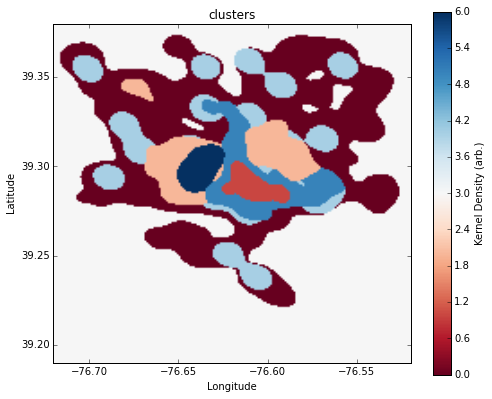

In [35]:
clusters = 7
model = KMeans(n_clusters=clusters)
model.fit(map_df)
neighborhoods = model.predict(map_df)
plt.hist(neighborhoods, bins=clusters)

plot_KDE(x, y, neighborhoods, 'clusters')

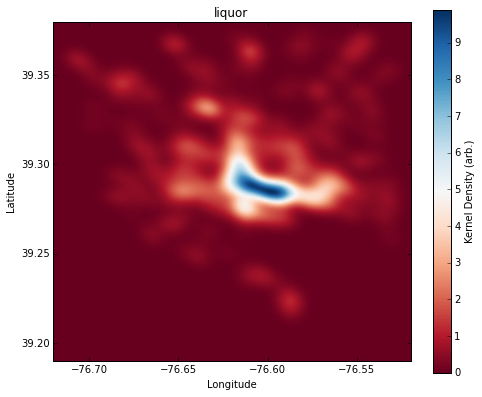

In [30]:
plot_KDE(x, y, map_df['liquor'], 'liquor')

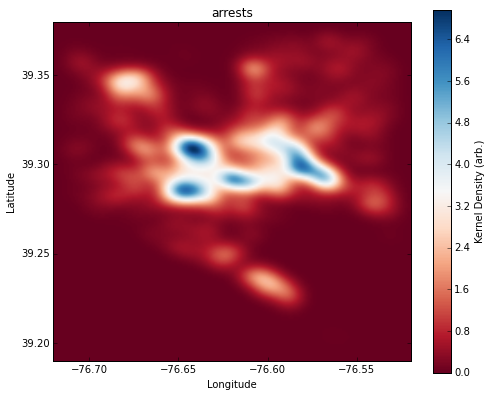

In [33]:
plot_KDE(x, y, map_df['crime'], 'arrests')